In [48]:
#initialization 
import matplotlib.pyplot as plt
import numpy as np

from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

#importing qiskit
from qiskit import IBMQ, Aer, assemble, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Operator

#import basic plot tools
from qiskit.visualization import plot_histogram

In [4]:
def initialize_s(qc, qubits):
    '''Apply H-gate to the qubits in "qubits"'''
    qc.h(qubits)

In [70]:
def phase_oracle(num_qubits, marked_states):
    '''Returns a phase_oracel circuit'''
    qc = QuantumCircuit(num_qubits, name="phase-oracle")
    oracle_matrix = np.identity(2**n)
    for q in marked_states:
        oracle_matrix[q, q] = -1
    Uf = Operator(oracle_matrix)
    qc.unitary(Uf, range(num_qubits))
    return qc

In [71]:
def diffuser(num_qubits):
    '''Returns a diffuser circuit'''
    qc = QuantumCircuit(num_qubits, name="diffuser")
    qc.h(range(num_qubits))
    qc.append(phase_oracle(num_qubits, [0]), range(n))
    qc.h(range(num_qubits))
    return qc

In [82]:
def Grover(num_qubits, marked_states):
    '''Returns a quantum for Grover's algorithm'''
    qc = QuantumCircuit(num_qubits, num_qubits, name="Grover")

    initialize_s(qc, range(num_qubits))
    #qc.barrier()
    m = len(marked_states)
    r = int(np.pi/(4*np.arcsin(1/np.sqrt(2**num_qubits/m))) - 0.5)
    print("{0} repetitions will be performed, given {1} qubits and {2} marked qubit(s)".format(r, num_qubits, m))

    for iteration in range(r):
        qc.append(phase_oracle(num_qubits, marked_states), range(num_qubits))
        qc.append(diffuser(num_qubits), range(num_qubits))

    #qc.barrier()
    qc.measure(range(num_qubits), range(num_qubits))

    return qc

In [83]:
n = 3
grover_circuit = Grover(n, [3]) 
#QuantumCircuit(n, n)
#grover_circuit.append(Grover(n, [0]), range(n))

#grover_circuit.draw()

1 repetitions will be performed, given 3 qubits and 1 marked qubit(s)


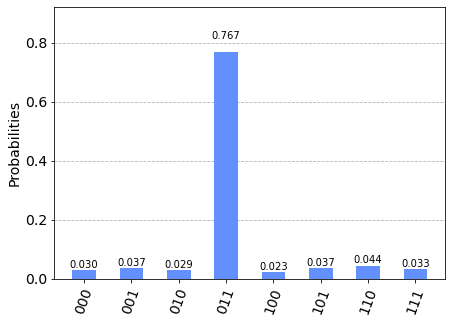

In [84]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(grover_circuit, backend=simulator, shots=1000).result().get_counts(grover_circuit)
plot_histogram(counts)

In [80]:
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

ibmqfactory.load_account:WARNING:2022-03-31 15:53:19,237: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibmq_lima


In [85]:
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

TranspilerError: "It was not possible to use the basis ['id', 'rz', 'sx', 'x', 'cx', 'reset']"